The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


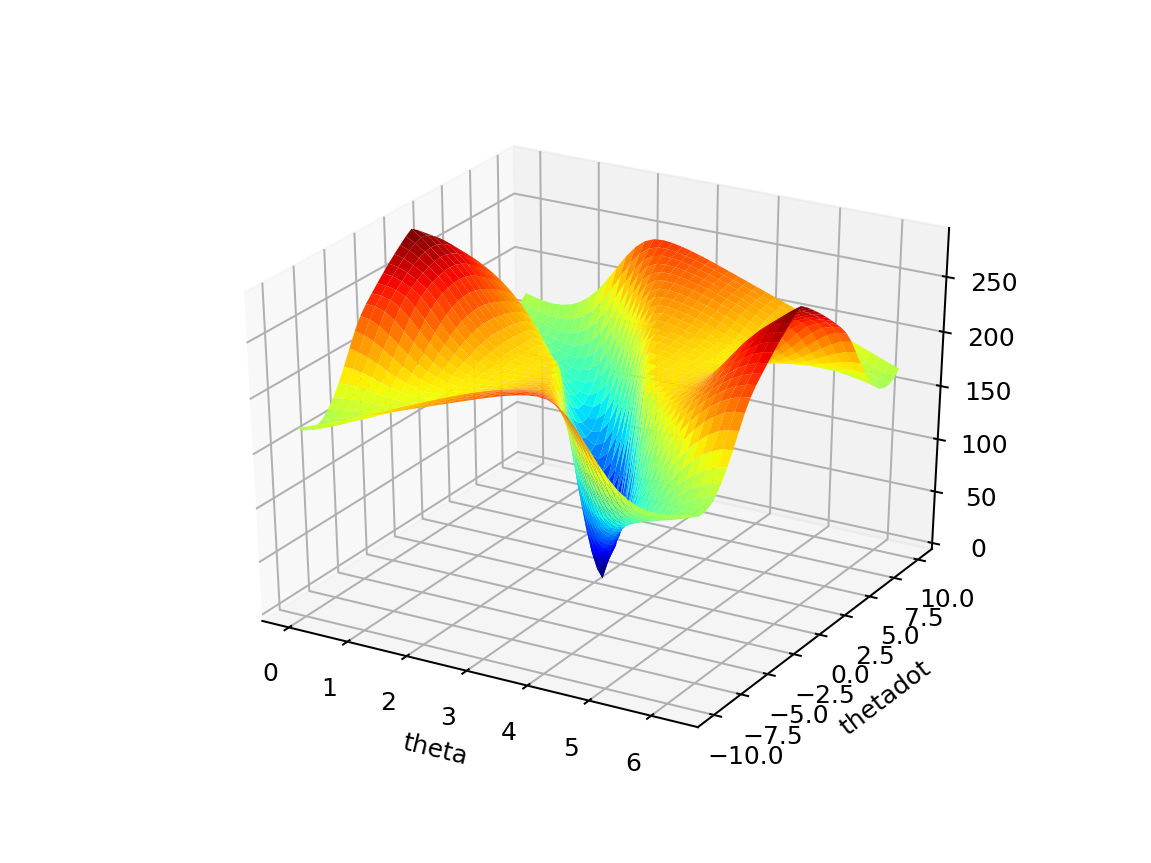

<IPython.core.display.Javascript object>


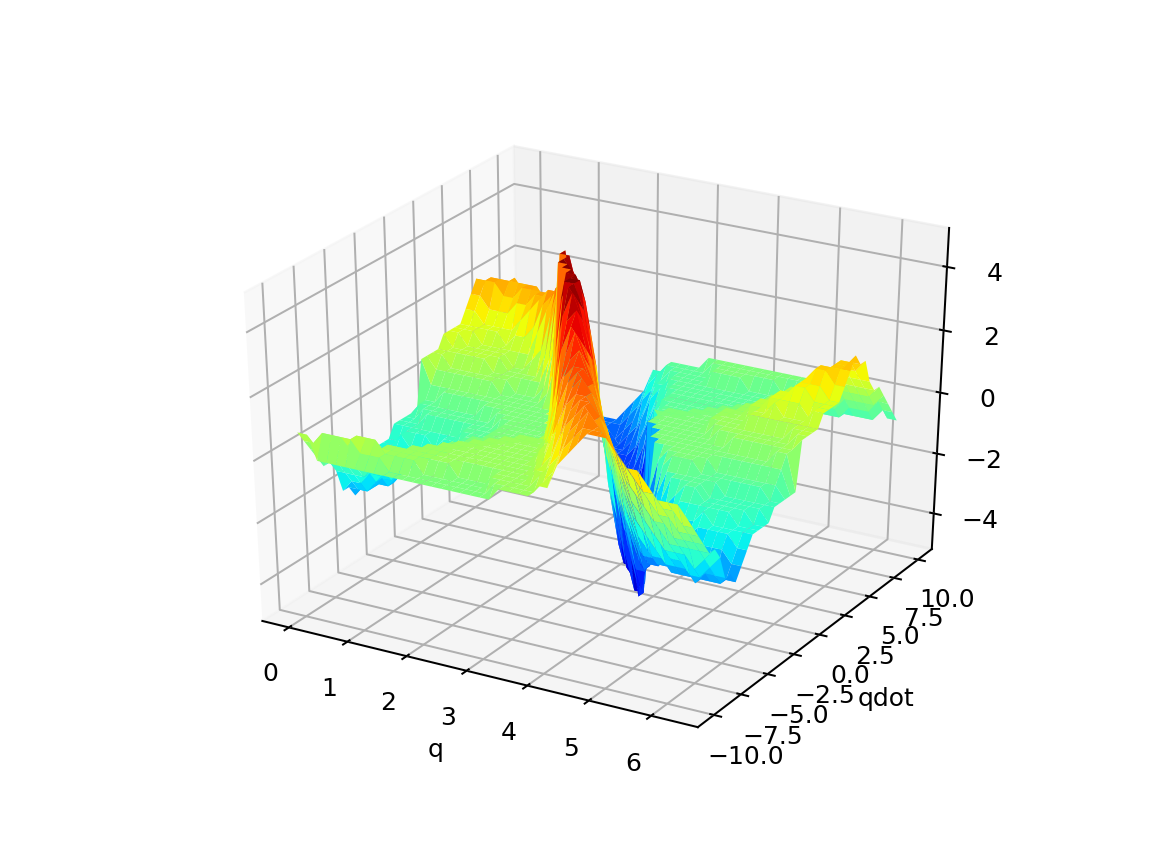

In [5]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import (DiagramBuilder, SignalLogger, Simulator, VectorSystem)
from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration, PeriodicBoundaryCondition)
from visualizer import PendulumVisualizer


expmt = "pendulum"
# expmt = "double_integrator"


plant = PendulumPlant()
simulator = Simulator(plant)
options = DynamicProgrammingOptions()


def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[0] = x[0] - math.pi
    if x.dot(x) < .5:
        return 0.
    return 1.


def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[0] = x[0] - math.pi
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return 2*x.dot(x) + 25*u.dot(u)


if (False):
    cost_function = min_time_cost
    input_limit = 5.
    options.convergence_tol = 0.001
else:
    cost_function = quadratic_regulator_cost
    input_limit = 5.
    options.convergence_tol = 0.001
    options.discount_factor = 1.

# qbins = np.hstack((np.linspace(0., math.pi-0.2, 5), np.linspace(math.pi-0.1, math.pi+0.1, 5), np.linspace(math.pi+0.2, 2*math.pi, 5)))
# qbins = np.linspace(0., math.pi*2, 23)
# qdotbins = np.hstack((np.linspace(-10., 10., 21)))
qbins = np.linspace(0., math.pi*2, 41)
qdotbins = np.hstack((np.linspace(-10., 10., 41)))
state_grid = [set(qbins), set(qdotbins)]
options.periodic_boundary_conditions = [
    PeriodicBoundaryCondition(0, 0., 2.*math.pi),
]
input_grid = [set(np.linspace(-input_limit, input_limit, 27))]
timestep = 0.0001

[Q, Qdot] = np.meshgrid(qbins, qdotbins)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")


def draw(iteration, mesh, cost_to_go, policy):
    # Drawing is slow, don't draw every frame.
    if iteration % 10 != 0:
        return
    plt.title("iteration " + str(iteration))
    J = np.reshape(cost_to_go, Q.shape)
    surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                           cmap=cm.jet)

    Pi = np.reshape(policy, Q.shape)
    surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

#     if plt.get_backend() != u'template':
    plt.draw_all()
    plt.pause(0.00001)

#     surf.remove()
#     surf2.remove()


# options.visualization_callback = draw

policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)

J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)


In [6]:
from pydrake.all import (BarycentricMesh, BarycentricMeshSystem)
experiment="pendulum"
def save_policy(name): # binds to policy and state_grid
    output_values = policy.get_output_values()
    np.save('numpy_saves/pi_b_mesh_init__'+experiment+'_'+name, state_grid)
    np.save('numpy_saves/pi_output_values__'+experiment+'_'+name, output_values)
    np.save('numpy_saves/ctg__'+experiment+'_'+name, cost_to_go)
def load_policy(name):
    b_mesh_init = np.load('numpy_saves/pi_b_mesh_init__'+experiment+'_'+name+'.npy').tolist()
    output_values = np.load('numpy_saves/pi_output_values__'+experiment+'_'+name+'.npy')
    b_mesh = BarycentricMesh(b_mesh_init)
    ctg = np.load('numpy_saves/ctg__'+experiment+'_'+name+'.npy')
    return BarycentricMeshSystem(b_mesh, output_values), ctg

# save_policy('good')
pi, ctg = load_policy('good')

## OK, let's try to fit with supervised learning

## Visualize the resultant super overfit thing

In [8]:
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)

In [57]:
# Animate the resulting policy.
builder = DiagramBuilder()
pendulum = builder.AddSystem(PendulumPlant())


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
class WrapTheta(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 2, 2)

    def _DoCalcVectorOutput(self, context, input, state, output):
        output[:] = input
        twoPI = 2.*math.pi
#         output[0] = output[0] - twoPI * math.floor(output[0] / twoPI)


wrap = builder.AddSystem(WrapTheta())
builder.Connect(pendulum.get_output_port(0), wrap.get_input_port(0))
vi_policy = builder.AddSystem(test)
builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), pendulum.get_input_port(0))
# Also log u's
logger_u = builder.AddSystem(SignalLogger(1))
# plot_trajectory(logger_u.data(), "tip_quiver", "pendulum", create_figure=False, symbol='-')))
logger_u._DeclarePeriodicPublish(0.001, 0.0)
builder.Connect(vi_policy.get_output_port(0), logger_u.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
logger._DeclarePeriodicPublish(0.001, 0.0)
builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
# state.SetFromVector([0, 1.5])

ic = (2.242066369111686, 4.055964784250426)
state.SetFromVector(ic)

In [58]:
simulator.StepTo(3.)

<IPython.core.display.Javascript object>


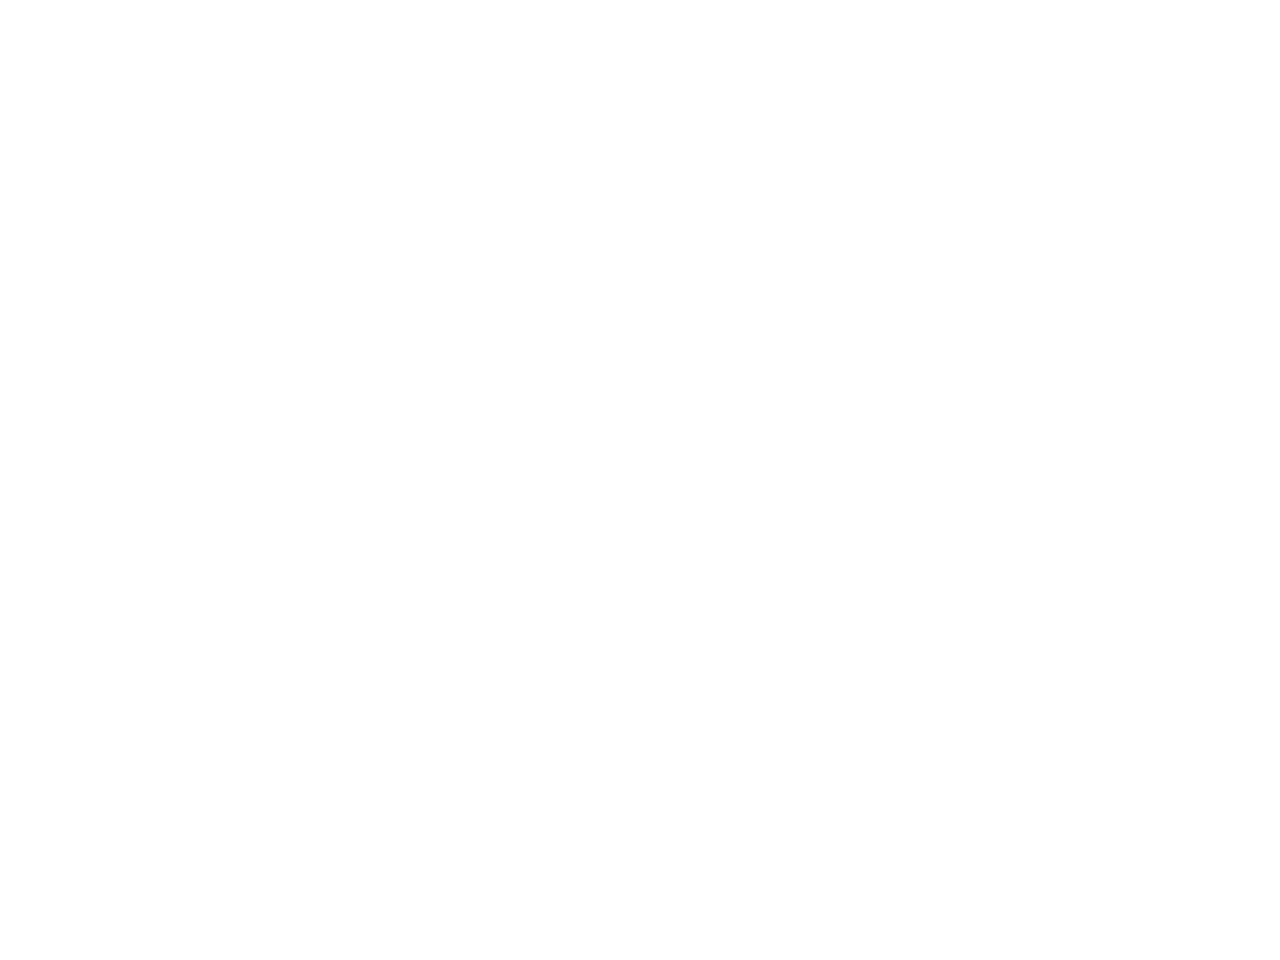

In [59]:
# Visualize the result as a video.
vis = PendulumVisualizer()
ani = vis.animate(logger, repeat=True)

# plt.show()
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

## Let's verify the cost to go against cost of many random (w/ random inits) dircols!

In [ ]:
from pydrake.all import (
    BarycentricMesh,
    DirectCollocation, 
    PiecewisePolynomial, 
    SolutionResult,
)
from traj.vi_utils import do_dircol_pendulum


def do_dircol(ic=(-1., 0.), warm_start="linear", seed=1776, should_vis=False):
    return do_dircol_pendulum(ic           = ic, 
                       warm_start   = warm_start, 
                       seed         = seed, 
                       should_vis   = should_vis,
                       num_samples  = 42, 
                       min_timestep = 0.2, 
                       max_timestep = 0.21)


# ic = (2.242066369111686, 4.055964784250426)
dircol, result = do_dircol(ic=ic, warm_start="linear", should_vis=False)
sum_cost        = np.sum(np.abs([dircol.EvalBindingAtSolution(cost) for cost in dircol.GetAllCosts()]))
sum_constraints = np.sum([np.sum(np.abs(dircol.EvalBindingAtSolution(constraint))) for constraint in dircol.GetAllConstraints()])
found_value     = sum_cost + sum_constraints

# Expected calculation with coord rounding
# nearest_xdot  = int(J.shape[0] * (ic[1] - -10)/(20))
# nearest_x     = int(J.shape[1] * (ic[0] - 0)/(2*math.pi))
# expected_value  = J[nearest_xdot][nearest_x]

# Expected calculation with Barycentric
bary_cost_to_go = BarycentricMesh(state_grid)
expected_value = bary_cost_to_go.Eval(cost_to_go.reshape(1, -1), np.array(ic))

print("ic={}, found_value= {:.2f} + {:.2f} = {:.2f}, expected_value= {}".format(ic, sum_cost, sum_constraints, found_value, expected_value))
# # for t in np.linspace(dircol.GetSampleTimes)
# print(dircol.ReconstructInputTrajectory(), dircol.ReconstructStateTrajectory())



def eval_policy(x):
    mesh = policy.get_mesh()
    ovs  = policy.get_output_values()
    return mesh.Eval(ovs, x)

# # On-knot
# times   = dircol.GetSampleTimes().T
# x_knots = dircol.GetStateSamples().T
# u_knots = dircol.GetInputSamples().T
# for t, x, u in zip(times, x_knots, u_knots):
#     expected_u = eval_policy(x)
#     found_u    = u
#     print("On-knot: {} vs {}".format(expected_u, found_u))

# # Off-knot
# x_trajectory   = dircol.ReconstructStateTrajectory()
# u_trajectory   = dircol.ReconstructInputTrajectory()
# for t in np.linspace(times[0], times[-1], 100): # Pick uniform 100 times along the trajectory!
#     x = x_trajectory.value(t)
#     u = u_trajectory.value(t)
#     expected_u = eval_policy(x)
#     found_u    = u[0] # To go from shape (1, 1) -> (1,)
#     print("Off-knot: {} vs {}".format(expected_u, found_u))

# # Below is an investigation...
# from traj.vis import (plot_trajectory)
# dircol.ReconstructStateTrajectory()
# # t_samples = dircol.GetSampleTimes()
# # x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])

# # WOW - insane agreement between traj opt and the policy... (for states...)
# if False:
#     plot_trajectory(dircol.GetStateSamples(), "tip_quiver", "pendulum", create_figure=True, symbol='-')
#     plot_trajectory(logger.data(), "tip_quiver", "pendulum", create_figure=False, symbol='-')

# # Let's check the agreement for the input u's
# N = 300
# if False:
#     plt.figure()
#     plt.plot(list(range(N)), dircol.GetInputSamples()[0], label="traj")
#     plt.plot(list(range(N)), logger_u.data()[0], label="sim")
#     plt.legend()
#     plt.show()

# # Ok, so will we see this same divergence if we plot x and x_dot versus time together?
# if False:
#     plt.figure()
#     plt.plot(list(range(N)), dircol.GetStateSamples()[0], label="traj")
#     plt.plot(list(range(N)), logger.data()[0], label="sim")
#     plt.legend()
#     plt.figure()
#     plt.plot(list(range(N)), dircol.GetStateSamples()[1], label="traj")
#     plt.plot(list(range(N)), logger.data()[1], label="sim")
#     plt.legend()
#     plt.show()

# # Ok, now let's manually calculate the costs and constraints
import copy
def cost(x, u):
    x = copy.deepcopy(x)
    u = copy.deepcopy(u)
    x[0] = x[0] - math.pi
    return 2*x.dot(x) + 25*u.dot(u)
traj_cost = 0
for x, u in zip(dircol.GetStateSamples().T, dircol.GetInputSamples().T):
#     print(x, u)
    traj_cost += cost(x, u) * 0.2 # For the timestep scaling!
    
sim_cost = 0
for x, u in zip(logger.data().T, logger_u.data().T):
#     print(x, u)
    sim_cost += cost(x, u) * 0.001 # For the timestep scaling!
    
print("traj_cost={} sim_cost={}".format(traj_cost, sim_cost))


In [37]:
cost_to_go.shape

(1681,)

0 making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a

MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a 

making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a p

<IPython.core.display.Javascript object>


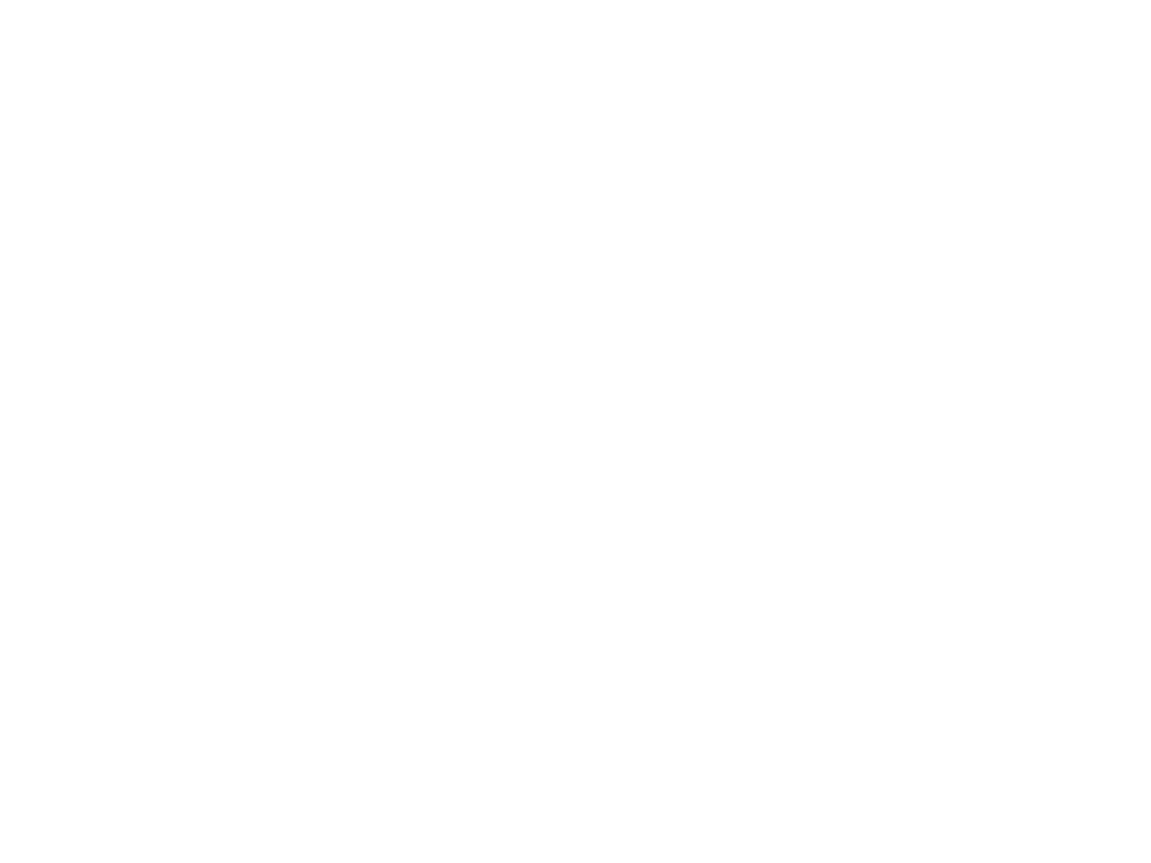

In [9]:
%matplotlib notebook


from pydrake.all import (SolutionResult)

# Gen a bunch of random initial conditions
n = 20
xs = np.random.uniform(0, 2*math.pi, n)
x_dots = np.random.uniform(-10, 10, n)
# ics = zip(xs, x_dots)
ics = [(x, x_dot) for x in xs for x_dot in x_dots]
# ics = [(4.9234397052604955, -8.284049094785054)]
# print(J.shape)

from traj.vi_utils import (do_dircol_pendulum)

# Do dircol from them
good_ics = [] # TODO: remove?
J = np.reshape(cost_to_go, Q.shape)
found_values, expected_values = [], []
SSE = 0
for i, ic in enumerate(ics):
    # TODO: turn on the random initializations!!
    if i % 50 == 0:
        print("{} ".format(i), end='')
    dircol, result  = do_dircol_pendulum(ic=ic, warm_start=None, seed=1776, should_vis=False)
    sum_cost        = np.sum(np.abs([dircol.EvalBindingAtSolution(cost) for cost in dircol.GetAllCosts()]))
    sum_constraints = np.sum([np.sum(np.abs(dircol.EvalBindingAtSolution(constraint))) for constraint in dircol.GetAllConstraints()])
    found_value     = sum_cost# + sum_constraints
    if result != SolutionResult.kSolutionFound:# or sum_cost > 350.:
        continue
#     else:
    good_ics.append(ic)
    found_values.append(found_value)
    
    # TODO: Expected value might need to rely on barycentric interpolation? consider using BarycentricMeshSystem
    # Do it via the distance between the lower bound and the upper bound, rounded to to the nearest bin?
    nearest_xdot  = int(J.shape[0] * (ic[1] - -10)/(20))
    nearest_x     = int(J.shape[1] * (ic[0] - 0)/(2*math.pi))
    expected_value  = J[nearest_xdot][nearest_x]
    expected_values.append(expected_value)
    SSE += (expected_value - found_value)**2
#     print("ic={}, found_value={}, expected_value={}".format(ic, found_value, expected_value))
MSE = SSE / n
print("MSE: {}".format(MSE))
    
# Plot expected vs actual, in a 3d graph, since we have a 2d state space...
# Here's the reference graph, in all of it's glory...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)

# 3d scatter for the actuals?
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
ax = fig.add_subplot(132, projection='3d')
xs, ys = zip(*good_ics)
zs = found_values
ax.scatter(xs, ys, zs, c='b', marker='^')

# Plot the residuals here!
ax = fig.add_subplot(133, projection='3d')
xs, ys = zip(*good_ics)
zs = np.array(expected_values) - np.array(found_values)
ax.scatter(xs, ys, zs, c='r', marker='^')
ctg_diffs = zs

## Let's evaluate the policy against (u, x) of many random (w/ random inits) dircols!

<type 'tuple'>
using_ics=  True
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!

making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a p

making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a pendulum plant...
MADE!!! a pendulum plant...
making a p

<IPython.core.display.Javascript object>


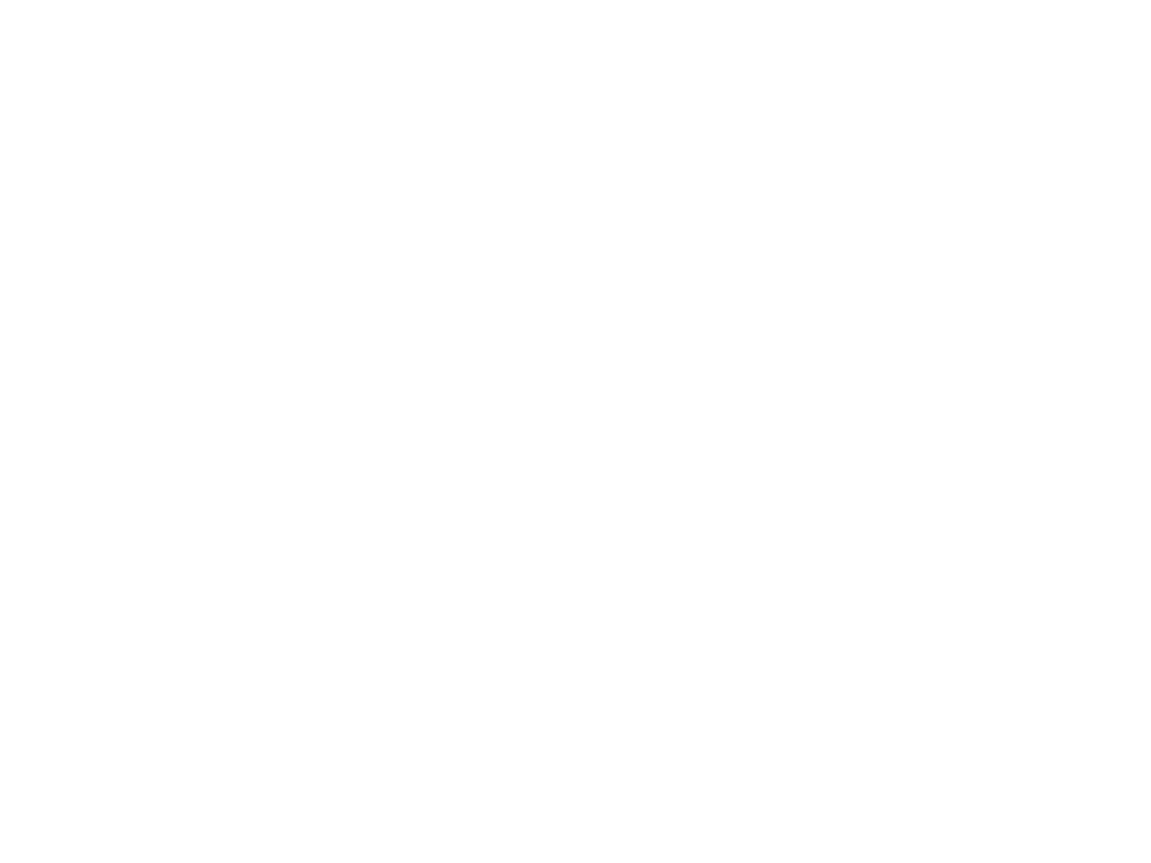

In [10]:
# Gen a bunch of random initial conditions
# n=15
# xs = np.random.uniform(0, 2*math.pi, n)
# x_dots = np.random.uniform(-10, 10, n)
# ics = [(x, x_dot) for x in xs for x_dot in x_dots]
ics = good_ics

from traj.vi_utils import (graph_vi_policy_vs_traj_knot_scatter)
print( str(type(ics[0])) )
x_vals, u_diffs = graph_vi_policy_vs_traj_knot_scatter(policy, ics, 
                                               combine_vi_policy_and_scatter=True,
                                               plot_residual=False,
                                               warm_start=None)

# I will explose outputing the array of diffs in traj.vi_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1, 378) (1, 378)


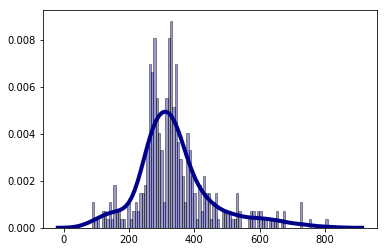

ctg_diffs: avg=339.26, std=114.81, MSE=48489017.29, MAE=339.26


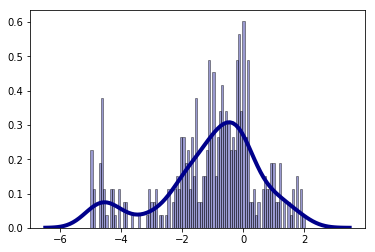

u_diffs: avg=-1.06, std=1.61, MSE=1409.73, MAE=1.40
(1, 378) (1, 378)
R = [[ 1.         -0.67558401]
 [-0.67558401  1.        ]]


Text(0,0.5,'u_diff')

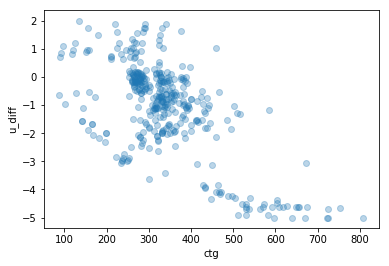

In [17]:
%matplotlib inline
%load_ext autoreload
%matplotlib inline
import seaborn as sns

good_ctg_diffs = -1*ctg_diffs.reshape(1, -1)
good_u_diffs = -1*u_diffs.reshape(1, -1)
print(good_ctg_diffs.shape, good_u_diffs.shape)

# from traj.vi_utils import (
#     plot_and_print_statistics
# )
def plot_and_print_statistics(diffs, name, bins=100, xlim=None, ax=None):
    # density plot
    if ax is None:
        fig = plt.figure()
        ax = fig.gca()
    sns.distplot(diffs, hist=True, kde=True, 
             bins=bins, # ???
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             ax=ax)
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
    avg = np.mean(diffs)
    std = np.std(diffs)
    MSE = np.sum(np.square(diffs))
    MAE = np.mean(np.abs(diffs))
    print("{}: avg={:.2f}, std={:.2f}, MSE={:.2f}, MAE={:.2f}".format(name, avg, std, MSE, MAE))


# cost_to_go     ctg_diffs
######################################################################
plot_and_print_statistics(good_ctg_diffs, "ctg_diffs")

# policy         u_diffs
######################################################################
plot_and_print_statistics(good_u_diffs, "u_diffs", 
#                           xlim=(-1, 1), 
#                           bins=500
                         )


# Here, I will plot all the VI and Policy things and evaluate correlation
######################################################################
print(good_ctg_diffs.shape, good_u_diffs.shape)
R = np.corrcoef(good_ctg_diffs, good_u_diffs)
print("R = {}".format(R))
plt.scatter(good_ctg_diffs, good_u_diffs, alpha=0.3)
plt.xlabel("ctg")
plt.ylabel("u_diff")


# Here I will generate the graph of for each subsection of cost_to_go graph,
# what is the distribution of policy outputs?
######################################################################



## Let's see what nets we can fit to this policy!

[1,   100] loss: 0.015
[2,   100] loss: 0.009
[3,   100] loss: 0.007
[4,   100] loss: 0.006
[5,   100] loss: 0.005
[6,   100] loss: 0.004
[7,   100] loss: 0.004
[8,   100] loss: 0.003
[9,   100] loss: 0.004
[10,   100] loss: 0.006
[11,   100] loss: 0.003
[12,   100] loss: 0.004
[13,   100] loss: 0.002
[14,   100] loss: 0.004
[15,   100] loss: 0.002
[16,   100] loss: 0.002
[17,   100] loss: 0.002
[18,   100] loss: 0.002
[19,   100] loss: 0.002
[20,   100] loss: 0.002
[21,   100] loss: 0.002
[22,   100] loss: 0.002
[23,   100] loss: 0.002
[24,   100] loss: 0.002
[25,   100] loss: 0.002
[26,   100] loss: 0.002
[27,   100] loss: 0.002
[28,   100] loss: 0.002
[29,   100] loss: 0.002
[30,   100] loss: 0.001
[31,   100] loss: 0.002
[32,   100] loss: 0.004
[33,   100] loss: 0.002
[34,   100] loss: 0.002
[35,   100] loss: 0.001
[36,   100] loss: 0.003
[37,   100] loss: 0.002
[38,   100] loss: 0.002
[39,   100] loss: 0.001
[40,   100] loss: 0.001
[41,   100] loss: 0.002
[42,   100] loss: 0.001
[

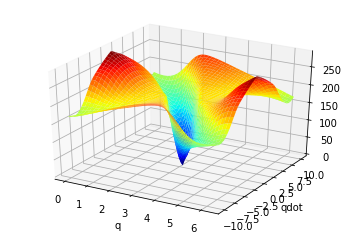

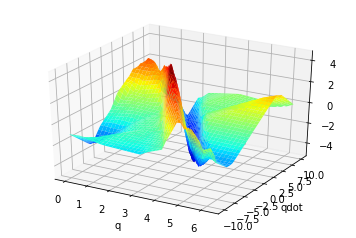

In [77]:
# SUPER OVERFITTING + L2 + parameter distance metric!
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from nn_system.networks import FC, FCBIG, MLPSMALL, MLP

# net = FCBIG(n_inputs=2, h_sz=8)
# net = FCBIG(n_inputs=2, h_sz=32) # <--- the one!
# net = MLPSMALL(n_inputs=2, h_sz=16)
# net = MLPSMALL(n_inputs=2, h_sz=32)
# net = MLP(n_inputs=2, h_sz=8)
net = MLP(n_inputs=2, h_sz=32)

criterion = nn.MSELoss(reduction="mean")
# optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.3)
optimizer = optim.Adam(net.parameters(), 5e-2)
# optimizer = optim.Adam(net.parameters(), 1e-3)
# optimizer = optim.Adam(net.parameters(), lr=1e-2) # For policy!

EPOCHS = 150

# My data
coords = zip(Q.flatten(), Qdot.flatten())
# cost_to_go
# policy.get_output_values()[0]

def my_gen():
    for _ in range(100):
#         idxs = np.random.uniform(0, np.prod(cost_to_go.shape), 483).astype(np.int)
#         inputs = np.array(coords)[idxs]
#         labels = np.array(cost_to_go).reshape(-1, 1)[idxs]
#     labels = policy.get_output_values()[0]

        inputs = np.array(coords)
#         labels = cost_to_go.reshape(-1, 1)
        labels = policy.get_output_values()[0].reshape(-1, 1)
        yield inputs, labels
    
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(my_gen(), 0):
        # Unpack data
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        # Forward pass
        outputs = net(inputs)
#         print(outputs.size())
        loss = criterion(outputs, labels)
#         print(loss.size())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0

print('Finished Training')


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("q")
ax.set_ylabel("qdot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")

J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
J_pred = np.reshape(net.forward(torch.tensor(coords)).data.numpy(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, J_pred, rstride=1, cstride=1,
                       cmap=cm.jet)

# Pi = np.reshape(policy.get_output_values(), Q.shape)
# surf = ax.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
#                         cmap=cm.jet)
# Pi_pred = np.reshape(net.forward(torch.tensor(coords)).data.numpy(), Q.shape)
# surf = ax2.plot_surface(Q, Qdot, Pi_pred, rstride=1, cstride=1,
#                        cmap=cm.jet)

## Can a net fit to this policy when it only get's stochastic samples of the known optimal policy

## Can traj opt inited with the above fitted optimal policy stay in place / find the optimal off of a small perturbation?

In [61]:
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import (
    DiagramBuilder,
    FloatingBaseType,
    RigidBodyTree,
    RigidBodyPlant,
    SignalLogger, 
    Simulator, 
    VectorSystem
)
from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration, PeriodicBoundaryCondition)
from visualizer import PendulumVisualizer
# from pydrake.examples.acrobot import AcrobotPlant
from underactuated import (
    PlanarRigidBodyVisualizer
)
from nn_system.NNSystem import NNSystem

# Animate the resulting policy.
builder = DiagramBuilder()
# tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
#                      FloatingBaseType.kFixed)
# plant = RigidBodyPlant(tree)
plant_system = builder.AddSystem(PendulumPlant())


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
class WrapTheta(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 2, 2)

    def _DoCalcVectorOutput(self, context, input, state, output):
        output[:] = input
        twoPI = 2.*math.pi
#         output[1] = output[1] - twoPI * math.floor(output[1] / twoPI)


wrap = builder.AddSystem(WrapTheta())
builder.Connect(plant_system.get_output_port(0), wrap.get_input_port(0))
vi_policy = builder.AddSystem(NNSystem(net))
# vi_policy = builder.AddSystem(policy)
builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), plant_system.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(plant_system.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
state.SetFromVector([0., math.pi])

In [62]:
simulator.StepTo(4.)

<IPython.core.display.Javascript object>


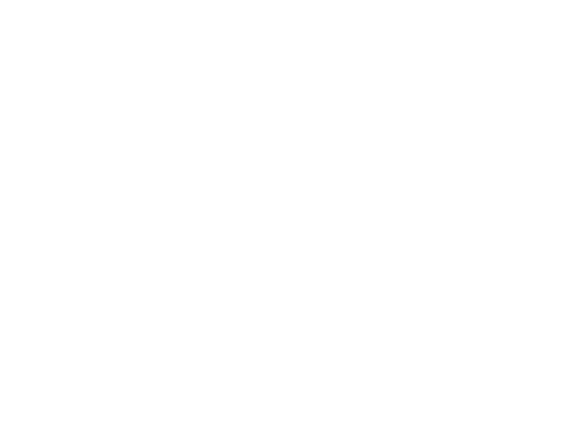

In [63]:
# Visualize the result as a video.
vis = PendulumVisualizer()
ani = vis.animate(logger, repeat=True)

# plt.show()
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())